In [6]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Question 1

In [7]:
def apply_frequency_filter(image, filter_type='ideal', pass_type='low', D0=50, n=2):
    # Convert  to float and normalize
    img = image.astype(np.float32) / 255.0
    M, N = img.shape

    # 2D FT and shift the zero-frequency component to the center
    F = np.fft.fftshift(np.fft.fft2(img))

    # Frequency grid
    u, v = np.meshgrid(np.arange(-M//2, M//2), np.arange(-N//2, N//2), indexing='ij')
    D = np.sqrt(u**2 + v**2)

    # Construct filter (LPF)
    if filter_type == 'ideal':
        H = np.double(D <= D0)
    elif filter_type == 'gaussian':
        H = np.exp(-(D**2) / (2 * (D0**2)))
    elif filter_type == 'butterworth':
        H = 1 / (1 + (D / D0)**(2 * n))
    else:
        raise ValueError("filter_type must be 'ideal', 'gaussian', or 'butterworth'")

    # High-pass filter: complement of low-pass
    if pass_type == 'high':
        H = 1 - H

    # Apply filter in frequency domain (correlated in time domain, multiplied in frequency domain)
    G = F * H

    # Inverse and shift back
    g = np.real(np.fft.ifft2(np.fft.ifftshift(G)))

    # rescaling
    g = np.clip(g, 0, 1)
    return g


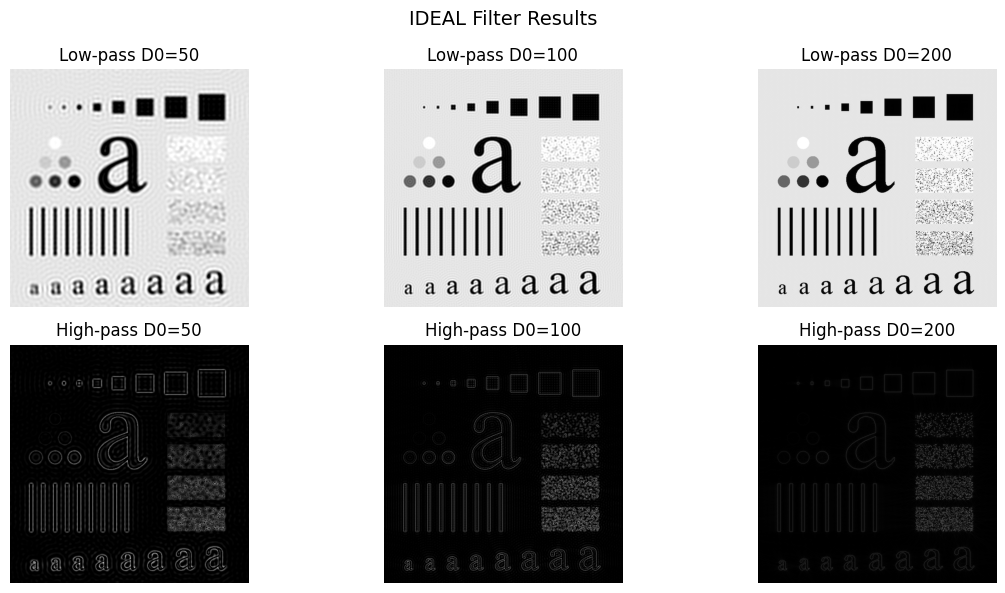

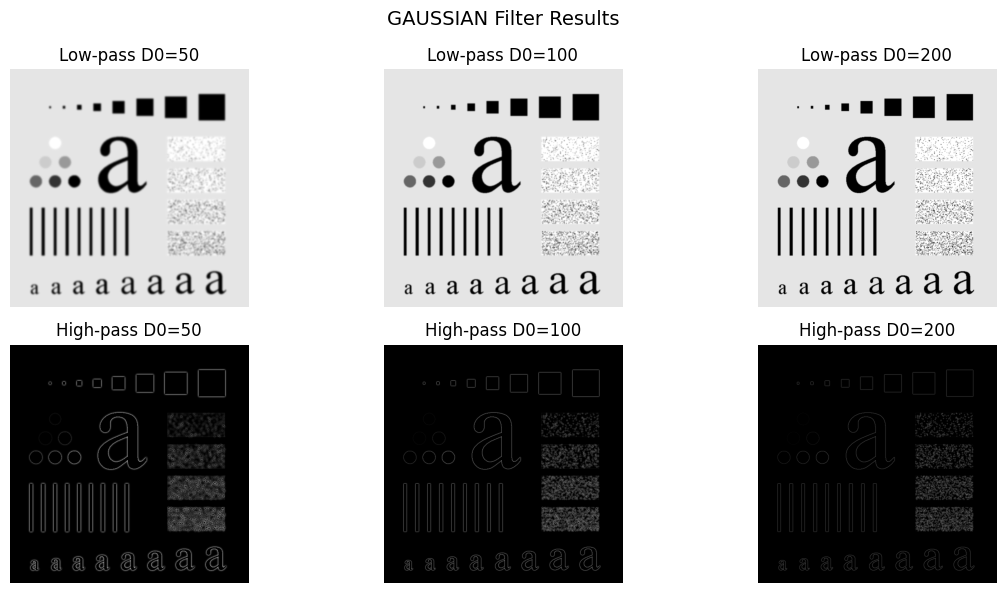

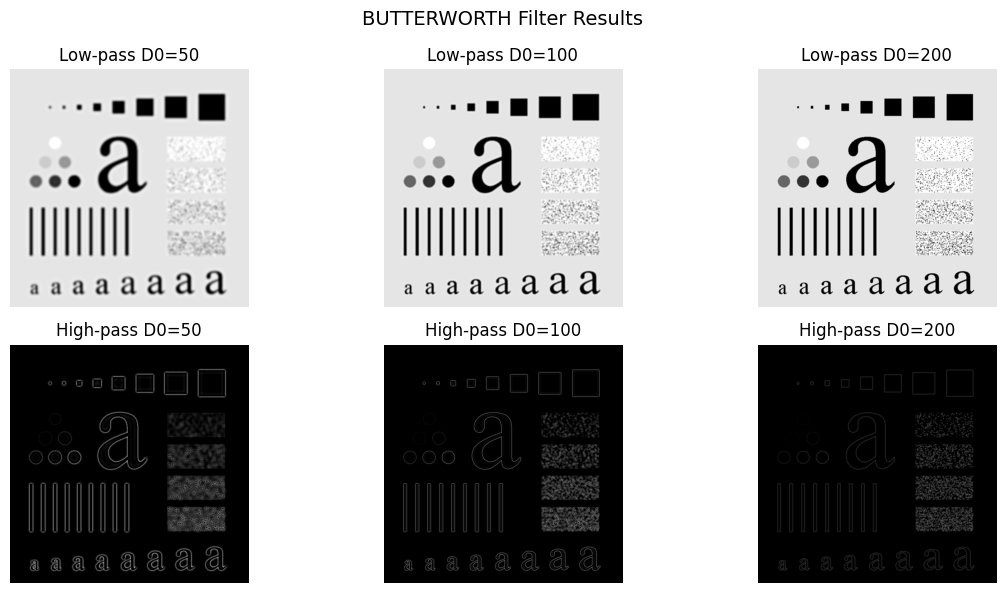

In [8]:
img = cv2.imread('a.tif', cv2.IMREAD_GRAYSCALE)

# parameters
kernel = [50, 100, 200]
filters = ['ideal', 'gaussian', 'butterworth']

for ftype in filters:
    plt.figure(figsize=(12, 6))
    plt.suptitle(f'{ftype.upper()} Filter Results', fontsize=14)

    for i, D0 in enumerate(kernel):
        low = apply_frequency_filter(img, ftype, 'low', D0)
        high = apply_frequency_filter(img, ftype, 'high', D0)

        # LPF
        plt.subplot(2, len(kernel), i + 1)
        plt.imshow(low, cmap='gray')
        plt.title(f'Low-pass D0={D0}')
        plt.axis('off')

        # HPF
        plt.subplot(2, len(kernel), i + 1 + len(kernel))
        plt.imshow(high, cmap='gray')
        plt.title(f'High-pass D0={D0}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

1. Fourier Transform of an Image

$\[F(u, v) = \sum_{x=0}^{M-1}\sum_{y=0}^{N-1} f(x, y) \, e^{-j2\pi\left(\frac{ux}{M} + \frac{vy}{N}\right)}\]$

$\[f(x, y) = \frac{1}{MN} \sum_{u=0}^{M-1}\sum_{v=0}^{N-1} F(u, v) \, e^{j2\pi\left(\frac{ux}{M} + \frac{vy}{N}\right)}\]$


2. Frequency Domain Filtering

$\[G(u, v) = H(u, v) \cdot F(u, v)\]$

Then the filtered image is obtained using the inverse Fourier transform:

$\[g(x, y) = \mathcal{F}^{-1}\{ G(u, v) \}\]$

$\[D(u, v) = \sqrt{(u - M/2)^2 + (v - N/2)^2}\]$

3. Filters
(a) Ideal Low-Pass Filter

$\[H(u, v) =\begin{cases}1, & D(u, v) \leq D_0 \\0, & D(u, v) > D_0\end{cases}\]$

   - Sharp cutoff at $\( D_0 \)$

(b) Gaussian Low-Pass Filter

$\[H(u, v) = e^{-\frac{D(u,v)^2}{2D_0^2}}\]$

- Smoothly decreases with distance

(c) Butterworth Low-Pass Filter

$\[H(u, v) = \frac{1}{1 + \left(\frac{D(u,v)}{D_0}\right)^{2n}}\]$

- $\( n \)$: filter order (controls the slope of the transition)
- Smoother than ideal but sharper than Gaussian
- Larger $\( n \)$ → steeper transition

An HPF preserves only the edges and sudden changes.

# Question 2

**Noise functions:**

In [9]:
def salt_pepper_noise(image, salt_prob=0.02, pepper_prob=0.02):
    noisy = image.copy()
    total_pixels = image.size
    # Salt (white pixels)
    num_salt = int(total_pixels * salt_prob)
    coords = [np.random.randint(0, i - 1, num_salt) for i in image.shape]
    noisy[coords[0], coords[1]] = 255
    # Pepper (black pixels)
    num_pepper = int(total_pixels * pepper_prob)
    coords = [np.random.randint(0, i - 1, num_pepper) for i in image.shape]
    noisy[coords[0], coords[1]] = 0
    return noisy

def sinusoidal_noise(image, A=50, freq_x=20, freq_y=40):
    rows, cols = image.shape
    x, y = np.meshgrid(np.arange(cols), np.arange(rows))
    sinusoid = A * np.sin(2 * np.pi * (freq_x * x / cols + freq_y * y / rows))
    noisy = image + sinusoid
    return np.clip(noisy, 0, 255).astype(np.uint8)

## A

In [15]:
def contraharmonic_mean_filter(img, size=3, Q=1.5):
    """
    Apply the Contraharmonic Mean Filter with numerical stability.
    """
    eps = 1e-8  # small constant to prevent division by zero
    padded = cv2.copyMakeBorder(img, size//2, size//2, size//2, size//2, cv2.BORDER_REFLECT)
    filtered = np.zeros_like(img, dtype=np.float64)

    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            region = padded[i:i+size, j:j+size].astype(np.float64)
            
            # Add epsilon before power to avoid division by zero(pepper)
            region_safe = region + eps
            
            num = np.sum(np.power(region_safe, Q + 1))
            den = np.sum(np.power(region_safe, Q))
            
            filtered[i, j] = num / den if den != 0 else 0

    return np.clip(filtered, 0, 255).astype(np.uint8)

## B

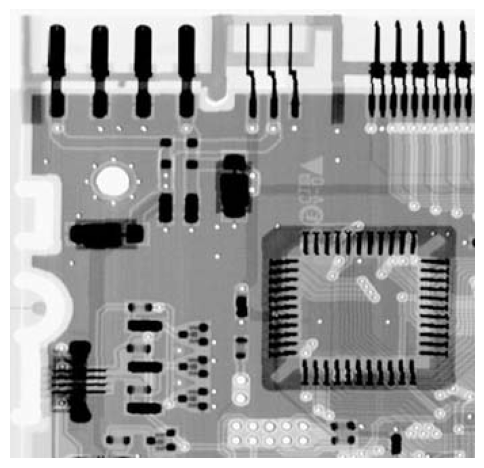

In [11]:
img = cv2.imread('IC.png', cv2.IMREAD_GRAYSCALE)
plt.figure(figsize=(6,6))
plt.imshow(img, cmap='gray')
plt.axis('off')
plt.show()

## C

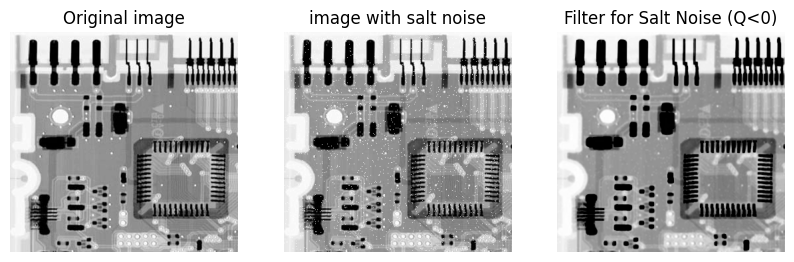

In [18]:
noisy_s = salt_pepper_noise(img, salt_prob=0.02, pepper_prob=0)
filtered_salt = contraharmonic_mean_filter(noisy_s, size=3, Q=-1.5) # AS the image is corrupted with salt noise. q = -1.5  causes the filter to give more weight to darker pixels in the neighborhood, effectively removing bright outliers. 


plt.figure(figsize=(10,4))
plt.subplot(1,3,1)
plt.imshow(img, cmap='gray')
plt.title('Original image')
plt.axis('off')
plt.subplot(1,3,2)
plt.imshow(noisy_s, cmap='gray')
plt.title('image with salt noise')
plt.axis('off')
plt.subplot(1,3,3)
plt.imshow(filtered_salt, cmap='gray')
plt.title('Filter for Salt Noise (Q<0)')
plt.axis('off')
plt.show()

The contraharmonic mean filter is defined as:

$\hat{f}(x, y) = \frac{\sum_{(s, t) \in S_{xy}} [g(s, t)]^{Q + 1}}{\sum_{(s, t) \in S_{xy}} [g(s, t)]^{Q}}$

where $g(s, t)$ represents the gray-level values in the neighborhood $S_{xy}$, and $Q$ is the order of the filter.

When $Q > 0$, the filter suppresses **pepper noise** (dark noise), because higher powers emphasize larger gray-level values and reduce the influence of small ones.

When $Q < 0$, the filter suppresses **salt noise** (bright noise), because negative powers amplify the effect of small gray-level values and reduce the effect of large ones. Therefore, bright pixels (such as salt noise) contribute very little to the sums, so their influence is minimized. Because salt pixels are very large, when there is a negative power, they shrink dramatically toward zero.
So the filter pays attention only to the normal and darker neighbors.

As a result, regions around black edges receive higher emphasis after filtering. The negative order $Q$ increases the contribution of low-intensity pixels, making edges appear darker and slightly enhancing black details while suppressing bright noise pixels.


## D

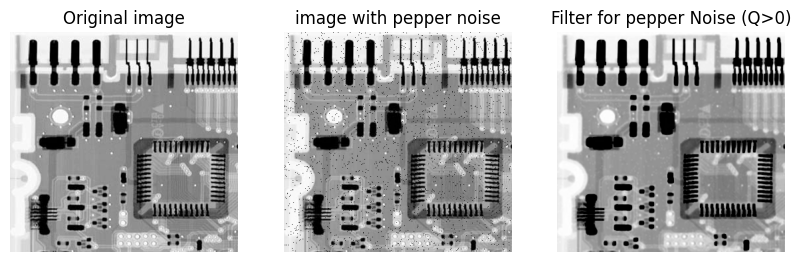

In [19]:
noisy_p = salt_pepper_noise(img, salt_prob=0, pepper_prob=0.02)
filtered_pepper = contraharmonic_mean_filter(noisy_p, size=3, Q=1.5)  # pepper noise

plt.figure(figsize=(10,4))
plt.subplot(1,3,1)
plt.imshow(img, cmap='gray')
plt.title('Original image')
plt.axis('off')
plt.subplot(1,3,2)
plt.imshow(noisy_p, cmap='gray')
plt.title('image with pepper noise')
plt.axis('off')
plt.subplot(1,3,3)
plt.imshow(filtered_salt, cmap='gray')
plt.title('Filter for pepper Noise (Q>0)')
plt.axis('off')
plt.show()

## E

In [14]:
noisy_sp = salt_pepper_noise(img)
noisy_sin = sinusoidal_noise(noisy_sp)

# Question 3

## alef

## be

## pe

## te

## se